In [32]:
%load_ext autoreload
%autoreload 2
import glob, sys
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.integrate import simps
import pyccl as ccl
import clmm
from clmm import Cosmology
def binning(corner): return [[corner[i],corner[i+1]] for i in range(len(corner)-1)]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
clmm.__version__

'1.10.0'

In [34]:
%load_ext autoreload
%autoreload 2
import CL_COUNT_modeling_completeness as comp
import CL_COUNT_modeling_purity as pur
import CL_COUNT_modeling_halo_mass_function as hmf
import CL_COUNT_modeling_richness_mass_relation as rm_relation
import CL_MASS_cluster_mass as cl_mass
import CL_COUNT_cluster_abundance as cl_count
import CL_LENSING_cluster_lensing as cl_lensing

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Hyper-parameters
## Hyper-parameters (non-cosmo)

In [35]:
#cosmology
Omega_c_true = 0.30711 - 0.048254
Omega_b_true = 0.048254
sigma8_true = .8288
Omegam_true = 0.30711
True_value = [Omega_c_true + Omega_b_true, sigma8_true]
cosmo_clmm = Cosmology(H0 = 71.0, Omega_dm0 = 0.265 - 0.0448, Omega_b0 = 0.0448, Omega_k0 = 0.0)
cosmo = ccl.Cosmology(Omega_c = Omega_c_true, Omega_b = Omega_b_true, h = 0.6777, sigma8 = sigma8_true, n_s=0.96)
#halo model
massdef = ccl.halos.massdef.MassDef('vir', 'critical',)# c_m_relation=None)
hmd = ccl.halos.hmfunc.MassFuncDespali16( mass_def=massdef)

## Hyper-parameters (non-cosmo)

In [36]:
#purity
a_nc, b_nc, a_rc, b_rc = np.log(10)*0.8612, np.log(10)*0.3527, 2.2183, -0.6592
theta_purity = [a_nc, b_nc, a_rc, b_rc]
#completeness
a_nc, b_nc, a_mc, b_mc = 1.1321, 0.7751, 13.31, 0.2025
theta_completeness = [a_nc, b_nc, a_mc, b_mc]
#rm_relation
log10m0, z0 = np.log10(10**14.2), .4
proxy_mu0, proxy_muz, proxy_mulog10m =  3.091, 0, 1.05*np.log(10)
proxy_sigma0, proxy_sigmaz, proxy_sigmalog10m =  0.594, 0., 0.026*np.log(10)
theta_rm = [log10m0, z0, proxy_mu0, proxy_muz, proxy_mulog10m, proxy_sigma0, proxy_sigmaz, proxy_sigmalog10m]

# Purity

In [37]:
richness_grid = np.logspace(np.log10(2), np.log10(500), 310)
logm_grid = np.linspace(11, 16, 30)
z_grid = np.linspace(.1, 1, 301)

# Cluster Abundance

In [116]:
z_edges = np.linspace(0.2, 1, 5)
Z_bin = binning(z_edges)
richness_edges = np.exp(np.linspace(np.log(20), np.log(200), 5))
Richness_bin = binning(richness_edges)

## effect of purity and completeness

In [117]:
bins = {'redshift_bins':Z_bin, 'richness_bins': Richness_bin}
grids = {'logm_grid': logm_grid, 'z_grid': z_grid, 'richness_grid':richness_grid}
count_modelling = {'dNdzdlogMdOmega':None,'richness_mass_relation':None, 'completeness':None, 'purity':None }
params = {'params_purity':theta_purity, 'params_completeness': theta_completeness, 'params_richness_mass_relation': theta_rm,
         'CCL_cosmology': cosmo, 'halo_mass_distribution': hmd}
adds = {'add_purity' : True, 'add_completeness':True}
compute = {'compute_dNdzdlogMdOmega':True,'compute_richness_mass_relation':True, 'compute_completeness':True, 'compute_purity':True }

In [118]:
#compute_count_modeling
%time count_modelling_new = cl_count.recompute_count_modelling(count_modelling, grids = grids, compute = compute, params = params)

CPU times: user 482 ms, sys: 64.1 ms, total: 546 ms
Wall time: 545 ms


In [119]:
print(count_modelling_new.keys())
print(compute)

dict_keys(['dNdzdlogMdOmega', 'richness_mass_relation', 'completeness', 'purity', 'richness_mass_relation - mean', 'richness_mass_relation - sigma'])
{'compute_dNdzdlogMdOmega': True, 'compute_richness_mass_relation': True, 'compute_completeness': True, 'compute_purity': True}


In [120]:
#define integrand
integrand_count = cl_count.define_count_integrand(count_modelling_new, adds)

In [121]:
Omega = (4*np.pi)
N = Omega * cl_count.Cluster_SurfaceDensity_ProxyZ(bins, integrand_count = integrand_count, grids = grids)

In [122]:
adds1 = {'add_purity' : False, 'add_completeness':False}
adds2 = {'add_purity' : True, 'add_completeness':False}
adds3 = {'add_purity' : False, 'add_completeness':True}
adds4 = {'add_purity' : True, 'add_completeness':True}
adds_list = [adds1, adds2, adds3, adds4]
list_dNdlambda = []
for adds in adds_list:
    integrand_count = cl_count.define_count_integrand(count_modelling_new, adds)
    list_dNdlambda.append(simps(integrand_count, logm_grid, axis=1))

# Lensing profiles

In [123]:
cosmo_clmm.get_rho_c(.1)

152241922857.01013

In [131]:
#cluster lensing
r = np.logspace(np.log10(.1), np.log10(20),10)
cluster_lensing_1h = cl_lensing.compute_cluster_lensing(r, 'Duffy08', logm_grid, z_grid, cosmo, cosmo_clmm, 
                                                                  two_halo=False, boost_factor=True)
cluster_lensing_1h_noboost = cl_lensing.compute_cluster_lensing(r, 'Duffy08', logm_grid, z_grid, cosmo, cosmo_clmm, 
                                                                two_halo=False, boost_factor=False)

In [132]:
NDS_profiles_Duffy_1h = Omega * cl_lensing.Cluster_dNd0mega_Lensing_ProxyZ(bins, integrand_count = integrand_count, cluster_lensing = cluster_lensing_1h, lensing_radius = r, grids = grids)
DS_profiles_Duffy_1h = NDS_profiles_Duffy_1h/N
NDS_profiles_Duffy_1h_noboost = Omega * cl_lensing.Cluster_dNd0mega_Lensing_ProxyZ(bins, integrand_count = integrand_count, cluster_lensing = cluster_lensing_1h_noboost, lensing_radius = r, grids = grids)
DS_profiles_Duffy_1h_noboost = NDS_profiles_Duffy_1h_noboost/N
#NDS_profiles_Duffy_2h = Omega * cl_lensing.Cluster_dNd0mega_Lensing_ProxyZ(bins, integrand_count = integrand_count, cluster_lensing = cluster_lensing_2h, lensing_radius = r, grids = grids)
#DS_profiles_Duffy_2h = NDS_profiles_Duffy_2h/N
#NDS_profiles_Diemer = Omega * cl_lensing.Cluster_dNd0mega_Lensing_ProxyZ(bins, integrand_count = integrand_count, cluster_lensing = cluster_lensing_2, lensing_radius = r, grids = grids)
#DS_profiles_Diemer = NDS_profiles_Diemer/N
#NDS_profiles_Prada = Omega * cl_lensing.Cluster_dNd0mega_Lensing_ProxyZ(bins, integrand_count = integrand_count, cluster_lensing = cluster_lensing_3, lensing_radius = r, grids = grids)
#DS_profiles_Prada = NDS_profiles_Prada/N

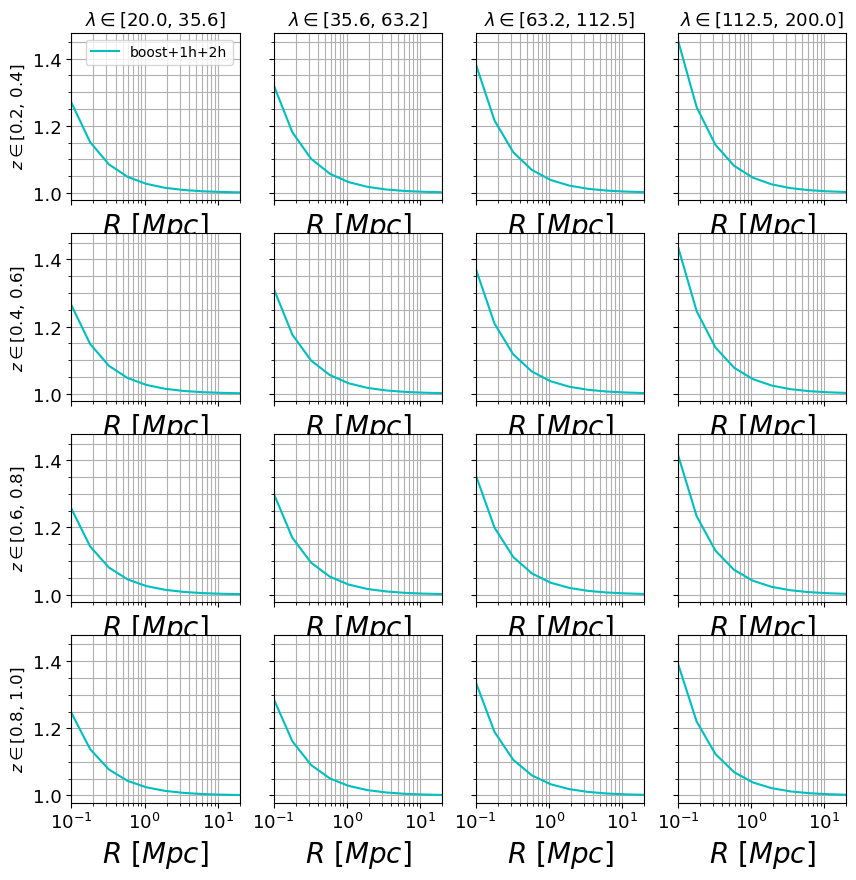

In [137]:
fig, ax = plt.subplots( len(Z_bin), len(Richness_bin), figsize = (10,10), sharey=True, sharex = True)
for i in range(len(Z_bin)):
    for j in range(len(Richness_bin)):
        label_z =  r'$ z \in $' + f'[{Z_bin[i][0]:.1f}, {Z_bin[i][1]:.1f}]'
        label_l = r'$ \lambda \in $' + f'[{Richness_bin[j][0]:.1f}, {Richness_bin[j][1]:.1f}]'
        ax[i,j].plot(r, DS_profiles_Duffy_1h_noboost[:,j,i]/DS_profiles_Duffy_1h[:,j,i], '-c', label = 'boost+1h+2h')
    #ax[i,j].loglog(r, DS_profiles_Duffy_1h_noboost[:,j,i], '--m', label = '1-halo')
       # ax[i,j].loglog(r, DS_profiles_Duffy_2h[:,j,i], '-r', label = '2-halo term')
       # ax[i,j].loglog(r, DS_profiles_Duffy[:,j,i], '--k')
       # ax[i,j].loglog(r, DS_profiles_Prada[:,j,i], '-m')
        ax[i,j].set_xlabel(r'$R\ [Mpc]$', fontsize=20)
        ax[i,0].set_ylabel(r'$\Delta\Sigma$', fontsize=20)
        ax[i,j].tick_params(axis='both', which="both", labelsize= 13)
        ax[i,j].set_xlim(.1, 20)
        ax[i,j].set_xscale('log')
        ax[i,j].minorticks_on()
        #ax[i,j].set_ylim(1e13,)
        ax[i,j].grid(True, )
        ax[i,j].grid(True, which='minor')
        ax[i,0].set_ylabel(label_z, fontsize = 12)
        ax[0,j].set_title(label_l, fontsize = 13)
ax[0,0].legend()
#plt.savefig('hlambdaf_ds.png', bbox_inches='tight', dpi=300)